# ======================================================================
# IMPROVED BERT-BASE & ROBERTA-BASE SENTIMENT ANALYSIS PROJECT
# ======================================================================


In [ ]:


from google.colab import drive
import os
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Standard imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import psutil
from tqdm.auto import tqdm
from scipy import stats
import time
from IPython.display import display

In [ ]:
# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def check_memory():
    """Check GPU and RAM memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")
    ram = psutil.virtual_memory()
    print(f"RAM Usage: {ram.percent}% ({ram.used/1024**3:.2f}GB/{ram.total/1024**3:.2f}GB)")

def cleanup_memory():
    """Clean up GPU and RAM memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        try:
            torch.cuda.ipc_collect()
        except:
            pass
    print("Memory cleaned up")

def create_directories(path):
    """Create directory if it doesn't exist"""
    os.makedirs(path, exist_ok=True)

In [ ]:
# =============================================================================
# DATASET CREATION
# =============================================================================

def create_dataset(texts, labels, tokenizer, max_length=128):
    """Create tokenized dataset from texts and labels"""
    input_ids, attention_masks = [], []
    print("Tokenizing texts...")

    # Reset texts index to avoid issues
    texts = texts.reset_index(drop=True)
    labels = labels.reset_index(drop=True)

    for text in tqdm(texts):
        # Handle potential NaN values
        if pd.isna(text):
            text = ""

        encoding = tokenizer(
            str(text).strip(),
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt',
            add_special_tokens=True
        )
        input_ids.append(encoding['input_ids'].flatten())
        attention_masks.append(encoding['attention_mask'].flatten())

    return {
        'input_ids': torch.stack(input_ids),
        'attention_masks': torch.stack(attention_masks),
        'labels': torch.tensor(labels.values, dtype=torch.long)
    }

In [ ]:
class SentimentDataset(Dataset):
    """Custom Dataset class for sentiment analysis"""
    def __init__(self, data_dict):
        self.input_ids = data_dict['input_ids']
        self.attention_masks = data_dict['attention_masks']
        self.labels = data_dict['labels']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [ ]:
# =============================================================================
# TRAINING AND EVALUATION
# =============================================================================

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def create_training_args(save_path, total_steps, epochs=7):
    """Create training arguments optimized for speed and performance"""
    return TrainingArguments(
        output_dir=save_path,
        num_train_epochs=epochs,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        gradient_accumulation_steps=1,
        learning_rate=3e-5,
        warmup_steps=int(0.05 * total_steps),  # 5% warmup
        weight_decay=0.01,
        label_smoothing_factor=0.1,
        logging_dir=f'{save_path}/logs',
        logging_steps=200,               # Monitor progress
        save_strategy="epoch",           # Save at epoch boundaries
        save_total_limit=2,
        load_best_model_at_end=True,     # Load best model after training
        metric_for_best_model="eval_loss",  # Use loss as metric
        greater_is_better=False,         # Lower loss is better
        eval_strategy="epoch",           # Evaluate once per epoch
        remove_unused_columns=True,      # Clean data preprocessing
        dataloader_pin_memory=True,      # Faster data loading
        dataloader_num_workers=4,        # Parallel data loading
        fp16=True,                       # Half precision for speed
        dataloader_drop_last=True,       # Consistent batch sizes
        report_to=None,                  # No external logging
        seed=42,
        data_seed=42,
        # Speed optimizations
        skip_memory_metrics=True,        # Skip memory logging overhead
        disable_tqdm=False,              # Keep progress bars
        prediction_loss_only=False,       # Only compute loss during eval
    )

In [ ]:
def train_model(model_name, train_data, val_data, save_path, model_type, epochs=3):
    """Train a model with LoRA fine-tuning"""
    print(f"\n{'='*50}")
    print(f"TRAINING {model_type.upper()} MODEL")
    print(f"{'='*50}")

    # Create save directory
    create_directories(save_path)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        problem_type="single_label_classification"
    )

    # Resize token embeddings if necessary
    model.resize_token_embeddings(len(tokenizer))

    # Freeze earlier layers for efficiency
    total_layers = getattr(model.config, 'num_hidden_layers', 12)
    layers_to_freeze = max(0, total_layers - 4)  # Keep last 4 layers unfrozen

    for name, param in model.named_parameters():
        if 'encoder.layer.' in name or 'roberta.encoder.layer.' in name:
            try:
                # Extract layer number more robustly
                parts = name.split('.')
                layer_idx = None
                for i, part in enumerate(parts):
                    if part == 'layer' and i + 1 < len(parts):
                        layer_idx = int(parts[i + 1])
                        break

                if layer_idx is not None and layer_idx < layers_to_freeze:
                    param.requires_grad = False
            except (ValueError, IndexError):
                continue

    peft_config = LoraConfig(
          task_type=TaskType.SEQ_CLS,
          r=16,
          lora_alpha=32,
          lora_dropout=0.1,
          target_modules=["query", "key", "value"],
          bias="none"
      )




    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    # Calculate total steps
    total_steps = (len(train_data) // 16) * epochs  # Adjusted for batch size

    # Create training arguments
    training_args = create_training_args(save_path, total_steps, epochs)

    # Create trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    print(f"Training completed in {training_time/60:.2f} minutes")

    # Save model and tokenizer
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)

    return model, tokenizer, training_time

In [ ]:
def evaluate_model(model, tokenizer, test_data, model_type, batch_size=32):
    """Evaluate model on test data"""
    print(f"\nEvaluating {model_type} model...")

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions, true_labels, probs = [], [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(test_data['input_ids']), batch_size)):
            end_idx = min(i + batch_size, len(test_data['input_ids']))

            batch_input_ids = test_data['input_ids'][i:end_idx].to(device)
            batch_attention_masks = test_data['attention_masks'][i:end_idx].to(device)
            batch_labels = test_data['labels'][i:end_idx]

            try:
                outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
                logits = outputs.logits

                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(batch_labels.numpy())
                probs.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())

            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                continue

In [ ]:
def evaluate_model(model, tokenizer, test_data, model_type, batch_size=32):
    """Evaluate model on test data"""
    print(f"\nEvaluating {model_type} model...")

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    predictions, true_labels, probs = [], [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(test_data['input_ids']), batch_size)):
            end_idx = min(i + batch_size, len(test_data['input_ids']))

            batch_input_ids = test_data['input_ids'][i:end_idx].to(device)
            batch_attention_masks = test_data['attention_masks'][i:end_idx].to(device)
            batch_labels = test_data['labels'][i:end_idx]

            try:
                outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
                logits = outputs.logits

                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(batch_labels.numpy())
                probs.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())

            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                continue

    # Calculate metrics
    acc = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=0)

    print(f"\n{model_type} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': predictions,
        'true_labels': true_labels,
        'probs': probs
    }

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_type):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_type} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_roc_curve(y_true, probs, model_type):
    """Plot ROC curve"""
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'{model_type} ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_type} ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def compare_models(bert_metrics, roberta_metrics):
    """Compare model performance"""
    comparison_df = pd.DataFrame([
        {'Model': 'BERT-base', **{k: v for k, v in bert_metrics.items() if k in ['accuracy', 'f1', 'precision', 'recall']}},
        {'Model': 'RoBERTa-base', **{k: v for k, v in roberta_metrics.items() if k in ['accuracy', 'f1', 'precision', 'recall']}}
    ])

    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    display(comparison_df.round(4))

    # Determine better model
    bert_f1 = bert_metrics['f1']
    roberta_f1 = roberta_metrics['f1']

    if bert_f1 > roberta_f1:
        print(f"\n BERT performs better with F1 score of {bert_f1:.4f}")
    elif roberta_f1 > bert_f1:
        print(f"\n RoBERTa performs better with F1 score of {roberta_f1:.4f}")
    else:
        print(f"\n Both models perform equally with F1 score of {bert_f1:.4f}")

    return comparison_df

In [ ]:
def predict_texts(texts, model, tokenizer, model_type):
    """Make predictions on new texts"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    print(f"\n{model_type} Predictions:")
    print("-" * 50)

    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(
                text,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1)
            confidence = probs.max().item()

            sentiment = 'Positive' if pred.item() == 1 else 'Negative'

            print(f"Text: {text}")
            print(f"Prediction: {sentiment} (Confidence: {confidence:.3f})")
            print()

In [ ]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================
print("BERT vs RoBERTa Sentiment Analysis Comparison")
print("=" * 60)

# Check initial memory
check_memory()

# Load and prepare dataset
print("\nLoading dataset...")

df = pd.read_csv("/content/drive/MyDrive/Final_project/processed_tweets.csv")
print(f"Dataset loaded successfully. Shape: {df.shape}")

# Check for required columns
required_columns = ['clean_tweet', 'sentiment']
if not all(col in df.columns for col in required_columns):
    print(f"Error: Required columns {required_columns} not found in dataset.")
    print(f"Available columns: {list(df.columns)}")


BERT vs RoBERTa Sentiment Analysis Comparison
GPU Memory - Allocated: 0.00GB, Cached: 0.00GB
RAM Usage: 5.0% (3.42GB/83.48GB)

Loading dataset...
Dataset loaded successfully. Shape: (1446756, 9)


In [ ]:
sample_size = 250000
# Balance the dataset
neg_samples = df[df['sentiment'] == 'Negative'].sample(sample_size, random_state=42)
pos_samples = df[df['sentiment'] == 'Positive'].sample(sample_size, random_state=42)

df_sample = pd.concat([neg_samples, pos_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Using balanced sample of {len(df_sample)} tweets")
print(f"Positive: {len(pos_samples)}, Negative: {len(neg_samples)}")

# Prepare data
texts = df_sample['clean_tweet']
labels = df_sample['sentiment'].map({'Negative': 0, 'Positive': 1})

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

cleanup_memory()

Using balanced sample of 500000 tweets
Positive: 250000, Negative: 250000
Train size: 350000, Val size: 50000, Test size: 100000
Memory cleaned up


In [ ]:
# Initialize results dictionary
results = {}

# Train BERT

print("\n" + "="*60)
print("TRAINING BERT MODEL")
print("="*60)

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_train_data = create_dataset(X_train, y_train, bert_tokenizer, max_length=128)
bert_val_data = create_dataset(X_val, y_val, bert_tokenizer, max_length=128)
bert_test_data = create_dataset(X_test, y_test, bert_tokenizer, max_length=128)

bert_train_dataset = SentimentDataset(bert_train_data)
bert_val_dataset = SentimentDataset(bert_val_data)


TRAINING BERT MODEL


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing texts...


  0%|          | 0/350000 [00:00<?, ?it/s]

Tokenizing texts...


  0%|          | 0/50000 [00:00<?, ?it/s]

Tokenizing texts...


  0%|          | 0/100000 [00:00<?, ?it/s]


TRAINING BERT MODEL
Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 886,274 || all params: 110,370,052 || trainable%: 0.8030


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.551800,0.540280,0.760663,0.760628,0.760817,0.760663
2,0.531900,0.530844,0.766425,0.766153,0.767671,0.766425
3,0.527300,0.523639,0.772187,0.772105,0.772582,0.772187
4,0.530000,0.526271,0.772067,0.771766,0.773510,0.772067
5,0.522800,0.518559,0.776368,0.776311,0.776652,0.776368
6,0.516300,0.520009,0.776468,0.776442,0.776599,0.776468
7,0.515000,0.519230,0.777449,0.777449,0.777449,0.777449


Training completed in 81.31 minutes

Evaluating BERT model...


  0%|          | 0/3125 [00:00<?, ?it/s]


BERT Results:
Accuracy: 0.7773
F1 Score: 0.7772
Precision: 0.7776
Recall: 0.7773


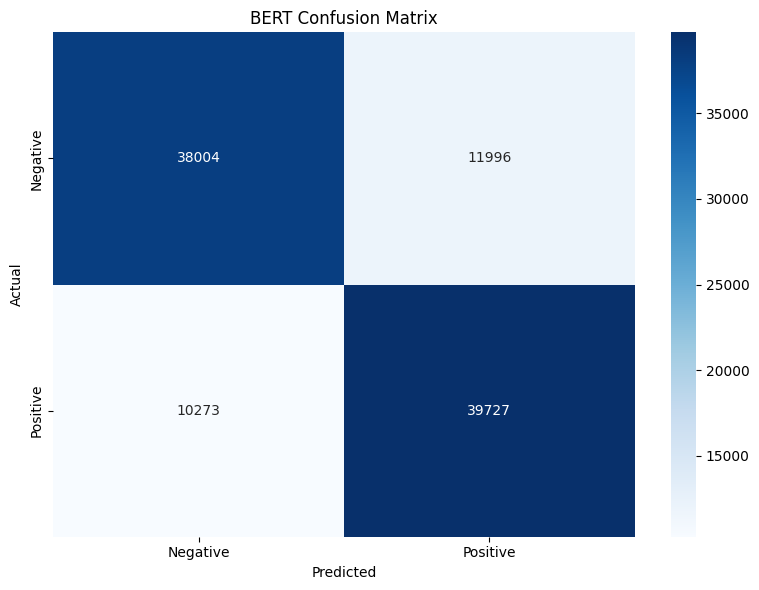

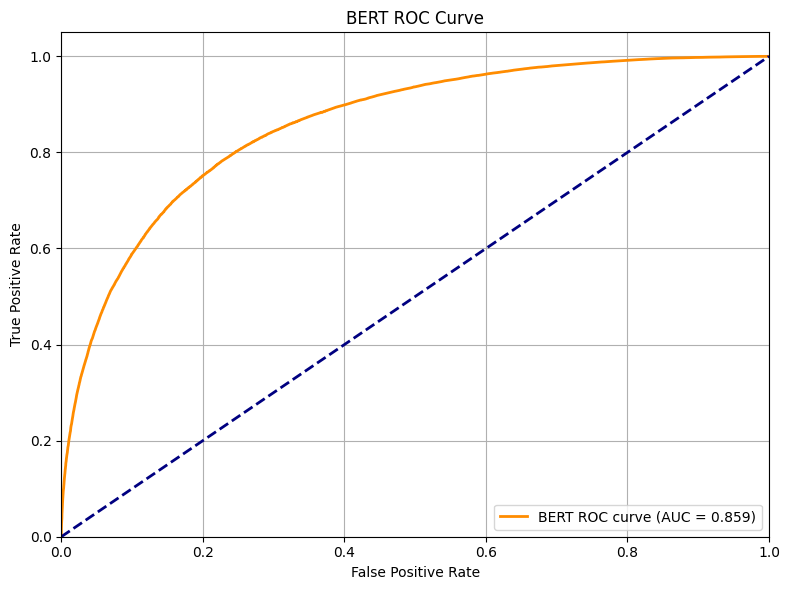

Memory cleaned up


In [ ]:
# Train BERT
bert_model, bert_tokenizer_trained, bert_training_time = train_model(
    model_name='bert-base-uncased',
    train_data=bert_train_dataset,
    val_data=bert_val_dataset,
    save_path='/content/drive/MyDrive/Model_weights_with_epochs/bert_sentiment_model',
    model_type='BERT',
    epochs=7
)

bert_results = evaluate_model(bert_model, bert_tokenizer_trained, bert_test_data, 'BERT')
results['bert'] = bert_results

# Plot results
plot_confusion_matrix(bert_results['true_labels'], bert_results['predictions'], 'BERT')
plot_roc_curve(bert_results['true_labels'], bert_results['probs'], 'BERT')

cleanup_memory()

In [ ]:
# Train RoBERTa
print("\n" + "="*60)
print("TRAINING ROBERTA MODEL")
print("="*60)

roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
roberta_train_data = create_dataset(X_train, y_train, roberta_tokenizer, max_length=128)
roberta_val_data = create_dataset(X_val, y_val, roberta_tokenizer, max_length=128)
roberta_test_data = create_dataset(X_test, y_test, roberta_tokenizer, max_length=128)

roberta_train_dataset = SentimentDataset(roberta_train_data)
roberta_val_dataset = SentimentDataset(roberta_val_data)


TRAINING ROBERTA MODEL


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing texts...


  0%|          | 0/350000 [00:00<?, ?it/s]

Tokenizing texts...


  0%|          | 0/50000 [00:00<?, ?it/s]

Tokenizing texts...


  0%|          | 0/100000 [00:00<?, ?it/s]


TRAINING ROBERTA MODEL
Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,476,866 || all params: 126,124,036 || trainable%: 1.1710


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.548900,0.526090,0.770947,0.770940,0.770979,0.770947
2,0.528300,0.517774,0.776789,0.776722,0.777119,0.776789
3,0.523500,0.513182,0.780950,0.780941,0.780994,0.780950
4,0.526800,0.521545,0.778729,0.778227,0.781276,0.778729
5,0.523000,0.509931,0.783491,0.783429,0.783814,0.783491
6,0.508900,0.510784,0.784791,0.784784,0.784828,0.784791
7,0.511300,0.509784,0.785131,0.785131,0.785134,0.785131


Training completed in 84.50 minutes

Evaluating RoBERTa model...


  0%|          | 0/3125 [00:00<?, ?it/s]


RoBERTa Results:
Accuracy: 0.7851
F1 Score: 0.7851
Precision: 0.7851
Recall: 0.7851


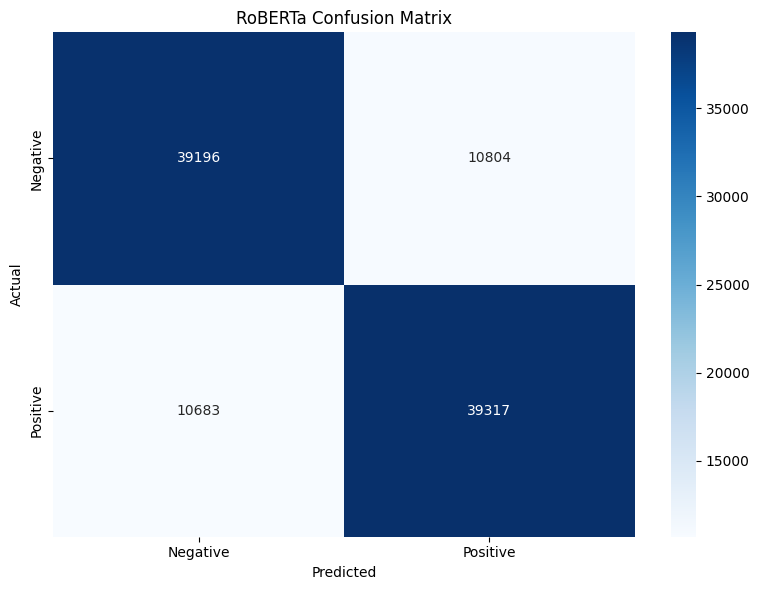

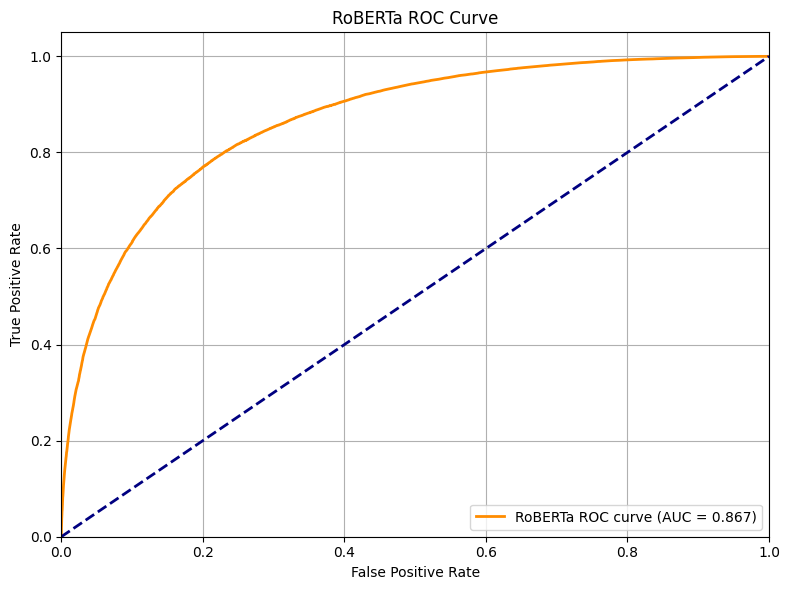

Memory cleaned up


In [ ]:
roberta_model, roberta_tokenizer_trained, roberta_training_time = train_model(
    model_name='roberta-base',
    train_data=roberta_train_dataset,
    val_data=roberta_val_dataset,
    save_path='/content/drive/MyDrive/Model_weights_with_epochs/roberta_sentiment_model',
    model_type='RoBERTa',
    epochs=7
)

roberta_results = evaluate_model(roberta_model, roberta_tokenizer_trained, roberta_test_data, 'RoBERTa')
results['roberta'] = roberta_results

# Plot results
plot_confusion_matrix(roberta_results['true_labels'], roberta_results['predictions'], 'RoBERTa')
plot_roc_curve(roberta_results['true_labels'], roberta_results['probs'], 'RoBERTa')

cleanup_memory()

In [ ]:
# Compare models
if 'bert' in results and 'roberta' in results:
    comparison_df = compare_models(results['bert'], results['roberta'])

    # Test on sample texts
    test_texts = [
        "I love this product! It's amazing and works perfectly!",
        "This is terrible. Worst experience ever. Very disappointed.",
        "The service was okay, nothing special but not bad either.",
        "Absolutely fantastic! Highly recommend to everyone!",
        "Not sure about this. Mixed feelings about the quality.",
        "At this speed, I might actually finish my degree before the page loads.",
        "I bought a laptop and it worked for only 2 days very well"
    ]

    print("\n" + "="*60)
    print("SAMPLE PREDICTIONS")
    print("="*60)

    if 'bert_model' in locals():
        predict_texts(test_texts, bert_model, bert_tokenizer_trained, 'BERT')

    if 'roberta_model' in locals():
        predict_texts(test_texts, roberta_model, roberta_tokenizer_trained, 'RoBERTa')

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)




MODEL COMPARISON


,Model,accuracy,f1,precision,recall
0,BERT-base,0.7773,0.7772,0.7776,0.7773
1,RoBERTa-base,0.7851,0.7851,0.7851,0.7851



 RoBERTa performs better with F1 score of 0.7851

SAMPLE PREDICTIONS

BERT Predictions:
--------------------------------------------------
Text: I love this product! It's amazing and works perfectly!
Prediction: Positive (Confidence: 0.922)

Text: This is terrible. Worst experience ever. Very disappointed.
Prediction: Negative (Confidence: 0.951)

Text: The service was okay, nothing special but not bad either.
Prediction: Negative (Confidence: 0.552)

Text: Absolutely fantastic! Highly recommend to everyone!
Prediction: Positive (Confidence: 0.941)

Text: Not sure about this. Mixed feelings about the quality.
Prediction: Negative (Confidence: 0.800)

Text: At this speed, I might actually finish my degree before the page loads.
Prediction: Positive (Confidence: 0.590)

Text: I bought a laptop and it worked for only 2 days very well
Prediction: Negative (Confidence: 0.554)


RoBERTa Predictions:
--------------------------------------------------
Text: I love this product! It's amazing a